In [1]:
%matplotlib inline
from __future__ import division, print_function
import os

In [2]:
!ls

Analyze Motif Dist In Sim.ipynb
compute_imp_scores.py
compute_imp_scores.pyc
compute_imp_scores.sh
config
dan_basset_keras_port
dinucshuff_motifs_inserted_sigthresh5e-6_sorted_naive_window_around_summit.bed.gz
imp_scores
insert_motifs_in_dincuc_shuff_regions.py
model_files
motif_hits_sorted_naive_window_around_summit.bed.gz
nonoverlap_dinucshuff_motifs_inserted_sigthresh5e-6_merged_universal_neg_representative_peaks.bed.gz
runs_perf-metric-auROC.db
sorted_naive_window_around_summit.bed.gz
sorted_naive_window_around_summit.fa.gz
Study Simulated Importance.ipynb
test_set_negatives.bed.gz
test_set_positives.bed.gz
train_dinucshuff_motifs_inserted_sigthresh5e-6_sorted_naive_window_around_summit.bed.gz
train_nonoverlap_dinucshuff_motifs_inserted_sigthresh5e-6_merged_universal_neg_representative_peaks.bed.gz
train_sim_model_from_preinit.sh
valid_labels.gz


In [3]:
!zcat test_set_positives.bed.gz | wc -l

18421


In [4]:
import gzip
from collections import namedtuple

MotifHit = namedtuple("MotifHit",['offset', 'motif_id',
                                  'motif_factor', 'motif_seq',
                                  'motif_strand', 'motif_sig'])
def parse_motif_hit(string):
    (offset,motif_id,motif_factor,
     motif_seq,motif_strand,motif_sig) = string.split(",")
    
    offset = int(offset)
    motif_sig = float(motif_sig)
    return MotifHit(offset=offset,
                    motif_id=motif_id,
                    motif_factor=motif_factor,
                    motif_seq=motif_seq,
                    motif_strand=motif_strand,
                    motif_sig=motif_sig)

def parse_sim_file(file_name):
    seqs = []
    motifs_arr = []
    seq_ids = []
    
    for line in gzip.open(file_name):
        line = line.rstrip("\n")
        chrom,start,end,seq_id,seq,motifs = line.split("\t")
        seqs.append(seq)
        motifs_arr.append([parse_motif_hit(x) for x in motifs.split(";")] if len(motifs) > 0 else [])
        seq_ids.append(seq_id)
    return seqs, motifs_arr, seq_ids

original_positives_seqs, original_positives_motifs, original_positives_ids = parse_sim_file("test_set_positives.bed.gz")
negatives_seqs, negatives_motifs, negatives_ids = parse_sim_file("test_set_negatives.bed.gz")

In [5]:
positives_seqs = original_positives_seqs[::10]
positives_motifs = original_positives_motifs[::10]
positives_ids = original_positives_ids[::10]

In [39]:
from collections import Counter
original_positives_motif_counts_in_central_300 = Counter([x.motif_factor+":"+x.motif_id for y in original_positives_motifs for x in y
                                       if (x.offset > 350 and (x.offset + len(x.motif_seq))<650)])
original_positives_motif_counts_outside_central_300 = Counter([x.motif_factor+":"+x.motif_id for y in original_positives_motifs for x in y
                                                      if (x.offset > 650 or (x.offset + len(x.motif_seq))<350)])
negatives_motif_counts_in_central_300 = Counter([x.motif_factor+":"+x.motif_id for y in negatives_motifs for x in y
                                       if (x.offset > 350 and (x.offset + len(x.motif_seq))<650)])
negatives_motif_counts_outside_central_300 = Counter([x.motif_factor+":"+x.motif_id for y in negatives_motifs for x in y
                                                      if (x.offset > 650 or (x.offset + len(x.motif_seq))<350)])


In [183]:
ratios_in_to_out_negatives = dict([(x,((negatives_motif_counts_in_central_300[x]+1)
                             *(7/3)/(negatives_motif_counts_outside_central_300[x]+1),
                   negatives_motif_counts_in_central_300[x]))
                   for x in negatives_motif_counts_in_central_300.keys()])
ratios_in_to_out_positives = dict([(x,((original_positives_motif_counts_in_central_300[x]+1)
                                       *(7/3)/(original_positives_motif_counts_outside_central_300[x]+1),
                                    original_positives_motif_counts_in_central_300[x],
                                    ratios_in_to_out_negatives[x]))
                                    for x in original_positives_motif_counts_in_central_300.keys()])
ratios_positives_to_negatives = dict([(x,((original_positives_motif_counts_in_central_300[x])
                                       *(len(negatives_seqs)/len(original_positives_seqs))/(negatives_motif_counts_in_central_300[x]),
                                       original_positives_motif_counts_in_central_300[x]))
                                    for x in original_positives_motif_counts_in_central_300.keys()])

sorted_motif_list = [(x, ratios_positives_to_negatives[x][0],
        ratios_in_to_out_positives[x][0],
        ratios_in_to_out_negatives[x][0],
        positives_motif_counts_in_central_300[x])
 for x,y in sorted(ratios_in_to_out_positives.items(), key=lambda x: -x[1][0])
 if (ratios_positives_to_negatives[x][0] > 1.5
     and ratios_in_to_out_positives[x][0] > 2
     and (ratios_in_to_out_positives[x][0] > ratios_in_to_out_negatives[x][0]*1.5)
     and positives_motif_counts_in_central_300[x] > 10)]
print("\n".join(str(x) for x in sorted_motif_list))
motif_ids_to_assess = [x[0] for x in sorted_motif_list]
print(motif_ids_to_assess)
motif_ids_to_assess_set = set(motif_ids_to_assess)

('HNF1B:M6282_1.02', 2.9417622694195185, 3.2372372372372378, 1.1204111600587372, 14)
('HNF4A:M4698_1.02', 4.069058579510268, 2.8727828746177373, 1.515895498898332, 75)
('HNF4G:M2286_1.02', 3.894936648697557, 2.7839951865222625, 1.570342205323194, 70)
('FOXA2:M4567_1.02', 1.724945201004461, 2.636217948717949, 1.617359413202934, 19)
('HNF1A:M6281_1.02', 2.5505599980664253, 2.5859872611464967, 1.215902140672783, 24)
('NR2F1:M6176_1.02', 3.1292275120786055, 2.28060263653484, 1.3951578037181152, 43)
('RXRG:M6462_1.02', 2.4932056600301085, 2.2206119162640903, 1.3033389926428978, 20)
('NR1H2:M6383_1.02', 1.8931048033271567, 2.0755813953488373, 1.3658536585365855, 17)
['HNF1B:M6282_1.02', 'HNF4A:M4698_1.02', 'HNF4G:M2286_1.02', 'FOXA2:M4567_1.02', 'HNF1A:M6281_1.02', 'NR2F1:M6176_1.02', 'RXRG:M6462_1.02', 'NR1H2:M6383_1.02']


In [184]:
from collections import defaultdict

motif_to_hit_locations = defaultdict(list)
motif_to_length = {}

for region_idx,motifs_arr in enumerate(positives_motifs):
    for motif in motifs_arr:
        if (motif.offset > 350 and (motif.offset + len(motif.motif_seq)) < 650):
            motif_id = motif.motif_factor+":"+motif.motif_id
            if (motif_id in motif_ids_to_assess):
                motif_to_hit_locations[motif_id].append((region_idx, motif.offset))
                if (motif_id in motif_to_length):
                    assert motif_to_length[motif_id] == len(motif.motif_seq)
                else:
                    motif_to_length[motif_id] = len(motif.motif_seq)

all_motif_lengths = sorted(set(motif_to_length.values()))


In [185]:
import numpy as np

negatives_subsample_factor = 100

#prepare negative windows
motif_length_to_negatives_locations = defaultdict(list)
val_lookup = {'a': 0, 'c': 0, 'g': 0, 't': 0, 'n':0, 'A': 1, 'C': 1, 'G':1, 'T':1, 'N':1}

for i,sequence in enumerate(positives_seqs):
    arr = np.array([val_lookup[x] for x in sequence])
    cumsum_arr = np.array([0]+list(np.cumsum(arr)))
    for motif_length in all_motif_lengths:
        windows_sums = cumsum_arr[motif_length:]-cumsum_arr[:-motif_length]
        null_windows = [(i,x) for x in np.nonzero(windows_sums==0)[0][::negatives_subsample_factor]
                        if x > 350 and x < (650-motif_length)]
        motif_length_to_negatives_locations[motif_length].extend(null_windows)


In [194]:
[(x,len(y)) for x,y in motif_length_to_negatives_locations.items()]

[(19, 3285), (12, 3695), (13, 3637), (14, 3566), (15, 3533)]

In [197]:
import h5py
import numpy as np
from sklearn.metrics import average_precision_score
import sys

model_ids = ["record_1_model_Ba1Th",
             "record_2_model_fijFp",
             "record_3_model_iNu96",
             "record_4_model_s3EVY",
             "record_5_model_k1Ccu",
             "record_6_model_X79UW",
             "record_7_model_XpjQJ",
             "record_8_model_XchY4",
             "record_9_model_8fTYg",
             "record_10_model_xpYJA"]

scoring_methods = ['scores_ism',
'scores_deeplift_rescale_dinucshuff',
'scores_deeplift_genomicsdefault_dinucshuff',
'scores_integrated_grad20_dinucshuff',
'scores_grad_times_inp_flatref',

'scores_integrated_grad20_avgposref',
'scores_deeplift_rescale_avgposref',
'scores_deeplift_genomicsdefault_avgposref',
'scores_integrated_grad20_flatref',
'scores_deeplift_rescale_flatref',
'scores_deeplift_genomicsdefault_flatref',

'scores_integrated_grad10_dinucshuff',
'scores_integrated_grad2_dinucshuff',
'scores_integrated_grad5_dinucshuff']

model_id_to_scoring_method_to_motif_to_auprc = defaultdict(lambda: defaultdict(dict))
model_id_to_scoring_method_to_motif_to_auprcoverbg = defaultdict(lambda: defaultdict(dict))
model_id_to_scoring_method_to_motif_to_ranks = defaultdict(lambda: defaultdict(dict))

def compute_motif_auprc_and_ranks_given_scores(
    scores,
    motif_length_to_negatives_locations,
    motif_to_hit_locations,
    motif_to_length):
    
    negatives_locations_scores = {}
    for motif_length in motif_length_to_negatives_locations:
        negatives_locations_scores[motif_length] = [
            np.sum(scores[x[0],x[1]:x[1]+motif_length]) for x in
            motif_length_to_negatives_locations[motif_length]]
    motif_to_auprc = {}
    motif_to_auprcoverbg = {}
    motif_to_ranks = {}
    for motif in motif_to_hit_locations:
        motif_length = motif_to_length[motif]
        hit_locations_scores = [
            np.sum(scores[x[0], x[1]:x[1]+motif_length]) for x in
            motif_to_hit_locations[motif]]
        y_true = ([1 for x in hit_locations_scores]
                  + [0 for x in negatives_locations_scores[motif_length]])
        sorted_negatives = np.array(sorted(negatives_locations_scores[motif_length]))
        hit_ranks = np.array([x/len(sorted_negatives) for
                     x in np.searchsorted(sorted_negatives, hit_locations_scores)])
        y_score = hit_locations_scores + negatives_locations_scores[motif_length]
        auprc = average_precision_score(y_true=y_true,
                                        y_score=y_score)
        motif_to_auprc[motif] = auprc
        motif_to_auprcoverbg[motif] = auprc/np.mean(y_true)
        motif_to_ranks[motif] = hit_ranks
    return motif_to_auprc, motif_to_auprcoverbg, motif_to_ranks

print("Computing with average or max scores")
#Compute with average scores
for scoring_method in scoring_methods:
    for op in ["average", "max"]:
        if (op=="average"):
            scores = np.mean([
                np.array(h5py.File("oneinten_imp_scores/imp_scores_"+model_id+".h5", "r")[scoring_method])
                    for model_id in model_ids], axis=0)
        else:
            assert op=="max"
            scores = np.max([
                np.array(h5py.File("oneinten_imp_scores/imp_scores_"+model_id+".h5", "r")[scoring_method])
                    for model_id in model_ids], axis=0)
        (motif_to_auprc,
         motif_to_auprcoverbg,
         motif_to_ranks) = compute_motif_auprc_and_ranks_given_scores(
                            scores=scores,
                            motif_length_to_negatives_locations=
                             motif_length_to_negatives_locations,
                            motif_to_hit_locations=
                             motif_to_hit_locations,
                            motif_to_length=motif_to_length) 
        model_id_to_scoring_method_to_motif_to_auprc[op][scoring_method] = motif_to_auprc
        model_id_to_scoring_method_to_motif_to_auprcoverbg[op][scoring_method] = motif_to_auprcoverbg
        model_id_to_scoring_method_to_motif_to_ranks[op][scoring_method] = motif_to_ranks

for model_id in model_ids:
    f = h5py.File("oneinten_imp_scores/imp_scores_"+model_id+".h5", "r")
    print("on",model_id)
    sys.stdout.flush()
    for scoring_method in scoring_methods:
        #print("\n",scoring_method,"\n")
        scores = np.array(f[scoring_method])      
        (motif_to_auprc,
         motif_to_auprcoverbg,
         motif_to_ranks) = compute_motif_auprc_and_ranks_given_scores(
                            scores=scores,
                            motif_length_to_negatives_locations=
                             motif_length_to_negatives_locations,
                            motif_to_hit_locations=
                             motif_to_hit_locations,
                            motif_to_length=motif_to_length)        
        model_id_to_scoring_method_to_motif_to_auprc[model_id][scoring_method] = motif_to_auprc
        model_id_to_scoring_method_to_motif_to_auprcoverbg[model_id][scoring_method] = motif_to_auprcoverbg
        model_id_to_scoring_method_to_motif_to_ranks[model_id][scoring_method] = motif_to_ranks


Computing with average or max scores
on record_1_model_Ba1Th
on record_2_model_fijFp
on record_3_model_iNu96
on record_4_model_s3EVY
on record_5_model_k1Ccu
on record_6_model_X79UW
on record_7_model_XpjQJ
on record_8_model_XchY4
on record_9_model_8fTYg
on record_10_model_xpYJA


In [214]:
sorted(list(enumerate(
model_id_to_scoring_method_to_motif_to_ranks["record_1_model_Ba1Th"]["scores_ism"]['HNF4A:M4698_1.02']
- model_id_to_scoring_method_to_motif_to_ranks["record_1_model_Ba1Th"]["scores_deeplift_rescale_dinucshuff"]['HNF4A:M4698_1.02'])),
       key=lambda x: x[1])

[(53, -0.44409849985847716),
 (56, -0.26917633739031976),
 (46, -0.10274554203226727),
 (26, -0.04160769883951321),
 (10, -0.03906028870648174),
 (55, -0.021794508915935484),
 (59, -0.01330314180583081),
 (43, -0.011604868383809808),
 (67, -0.009906594961788806),
 (37, -0.008208321539767915),
 (73, -0.0067930936880837844),
 (1, -0.005660911406736413),
 (38, -0.004245683555052393),
 (28, -0.003962637984715522),
 (36, -0.003679592414378652),
 (63, -0.0033965468440418922),
 (15, -0.002830455703368262),
 (4, -0.002264364562694521),
 (69, -0.002264364562694521),
 (62, -0.0016982734220208906),
 (2, -0.0005660911406737412),
 (9, -0.0005660911406736302),
 (41, -0.0005660911406736302),
 (7, -0.0002830455703368706),
 (8, -0.0002830455703368706),
 (19, -0.0002830455703368706),
 (21, -0.0002830455703368706),
 (23, -0.0002830455703368706),
 (24, -0.0002830455703368706),
 (27, -0.0002830455703368706),
 (29, -0.0002830455703368706),
 (31, -0.0002830455703368706),
 (45, -0.0002830455703368706),
 (47, 

In [215]:
#(53, -0.44409849985847716),
# (56, -0.26917633739031976),
# (46, -0.10274554203226727),
# (26, -0.04160769883951321),
# (10, -0.03906028870648174),


(1499, 352)

cttttcaaacaatggtagagaaggaggcccaagcaggtagtgttcttctcTTGGCCTCTGGACTTGtttgaatcagttgctcacctctaggatggccacaatgtgctgccgattagttgcttaacaagtctaactcctttgtccacctctctgctctctgtactccccaatctgagctatgaggaaagtctcctcatggtacaggctttcagttcccataaattggttagtctagcagtacctggggtattcaggctgactAACAATCTGCAGTGCCttctattggcagcacacgctgtg


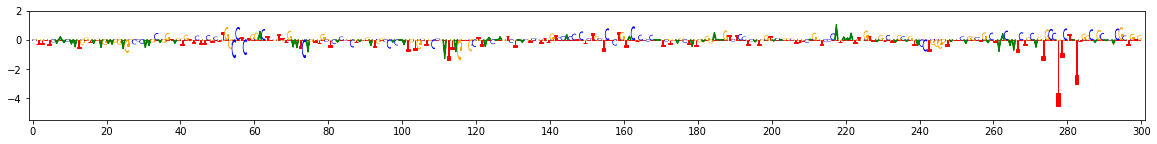

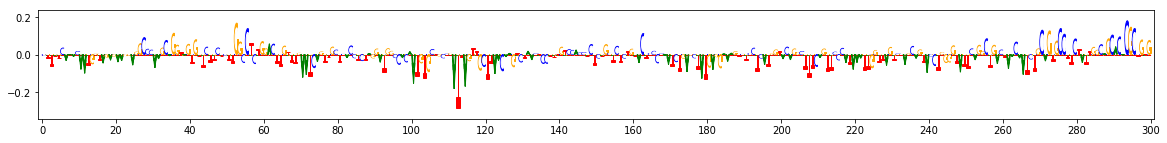

In [218]:
model_id = "record_1_model_Ba1Th"
f = h5py.File("oneinten_imp_scores/imp_scores_"+model_id+".h5", "r")
onehot = f["onehot"]
ism_scores = f["scores_ism"]
deeplift_rescale_scores = f['scores_deeplift_rescale_dinucshuff']
ig_scores = f['scores_integrated_grad20_dinucshuff']

from deeplift.visualization import viz_sequence
idx = motif_to_hit_locations['HNF4A:M4698_1.02'][26][0]
print(positives_seqs[idx][350:650])
viz_sequence.plot_weights((onehot[idx]*ism_scores[idx][:,None])[350:650],
                          subticks_frequency=20)
viz_sequence.plot_weights((onehot[idx]*deeplift_rescale_scores[idx][:,None])[350:650],
                          subticks_frequency=20)


In [220]:

#Hard to interpret the results on the motifs with weaker support...
for selected_motif in ['HNF4A:M4698_1.02',
                       'HNF4G:M2286_1.02',
                       'NR2F1:M6176_1.02',
                       'HNF1A:M6281_1.02',
                       'RXRG:M6462_1.02',
                       'FOXA2:M4567_1.02',
                       'NR1H2:M6383_1.02',
                       'HNF1B:M6282_1.02'
                      ]:
    print(selected_motif)
    for scoring_method in scoring_methods:
        print(scoring_method,
              np.mean(model_id_to_scoring_method_to_motif_to_ranks["average"][scoring_method][selected_motif]))
        print(scoring_method,
              np.mean(
               [np.mean(model_id_to_scoring_method_to_motif_to_ranks[model_id][scoring_method][selected_motif])
                for model_id in model_ids] 
              ))
        #print(scoring_method,model_id_to_scoring_method_to_motif_to_auprcoverbg
        #         ["max"][scoring_method][selected_motif])
    #for scoring_method in scoring_methods:
    #    print(scoring_method)
    #    for model_id in ["average"]+model_ids:
    #        print(model_id_to_scoring_method_to_motif_to_auprcoverbg
    #              [model_id][scoring_method][selected_motif])

HNF4A:M4698_1.02
scores_ism 0.9825417492216244
scores_ism 0.9699518822530425
scores_deeplift_rescale_dinucshuff 0.9908519671667139
scores_deeplift_rescale_dinucshuff 0.9858835739220682
scores_deeplift_genomicsdefault_dinucshuff 0.9919728276252476
scores_deeplift_genomicsdefault_dinucshuff 0.9860050948202659
scores_integrated_grad20_dinucshuff 0.9913878667798849
scores_integrated_grad20_dinucshuff 0.9834667421454852
scores_grad_times_inp_flatref 0.9955127842249267
scores_grad_times_inp_flatref 0.9871659590527407
scores_integrated_grad20_avgposref 0.9912444570242473
scores_integrated_grad20_avgposref 0.983715444853288
scores_deeplift_rescale_avgposref 0.9901009529200866
scores_deeplift_rescale_avgposref 0.9832897443155014
scores_deeplift_genomicsdefault_avgposref 0.9909840550995377
scores_deeplift_genomicsdefault_avgposref 0.9837863949429192
scores_integrated_grad20_flatref 0.9902443626757241
scores_integrated_grad20_flatref 0.9825745825077836
scores_deeplift_rescale_flatref 0.9882479479

In [203]:
sorted([(x,len(y)) for x,y in motif_to_hit_locations.items()],
        key=lambda x: -x[1])
#[x[0] for x in sorted([(x,len(y)) for x,y in motif_to_hit_locations.items()],
#        key=lambda x: -x[1])]

[('HNF4A:M4698_1.02', 75),
 ('HNF4G:M2286_1.02', 70),
 ('NR2F1:M6176_1.02', 43),
 ('HNF1A:M6281_1.02', 24),
 ('RXRG:M6462_1.02', 20),
 ('FOXA2:M4567_1.02', 19),
 ('NR1H2:M6383_1.02', 17),
 ('HNF1B:M6282_1.02', 14)]

In [ ]:
#HNF4A:M4698_1.02
#NR2F1:M6176_1.02 is similar to HNF

In [ ]:
['CREB3:M5323_1.02', 'HNF1B:M6282_1.02', 'HNF4A:M4698_1.02', 'HNF4G:M2286_1.02', 'DMBX1:M5345_1.02', 'FOXA2:M4567_1.02', 'HNF1A:M6281_1.02', 'XBP1:M6536_1.02', 'NR2F1:M6176_1.02', 'RXRG:M6462_1.02', 'NR1H2:M6383_1.02', 'HIF1A:M6275_1.02', '(SP5)_(Drosophila_melanogaster)_(DBD_0.93):M5209_1.02', 'TCF7L1:M5903_1.02', 'NR2F6:M6392_1.02', '(KLF12)_(Mus_musculus)_(DBD_1.00):M0443_1.02', '(KLF7)_(Mus_musculus)_(DBD_1.00):M0405_1.02', '(ZFP161)_(Mus_musculus)_(DBD_1.00):M0432_1.02', 'NR6A1:M6397_1.02', 'E2F4:M4537_1.02']